In [2]:
from qiskit_ibm_runtime import QiskitRuntimeService

lcl_token = "TOKEN HERE"

service = QiskitRuntimeService(
    channel="ibm_quantum", instance="ibm-q/open/main", token=lcl_token
)

In [3]:
from pyqsp.angle_sequence import QuantumSignalProcessingPhases
from pyqsp.response import PlotQSPResponse
from pyqsp.poly import StringPolynomial
from numpy.polynomial import Polynomial

from qiskit import QuantumCircuit
import numpy as np
from qiskit_ibm_runtime import Sampler, Options

import matplotlib as mpl

import json

# installed tensorflow, seaborn, pyqsp, qiskit_ibm_runtime onto default env

In [4]:
def get_phi(d):
    # Note: d is degree
    print(f"Evaluating get_phi({d})")
    # Warning: Time consuming [~ 1 min] since uses more accurate tensorflow to compute phis
    epsilon = 0.1
    k = 15
    b = k * k * np.log(k/epsilon)
    print(f"b = {b}")
    poly_314x_degd = StringPolynomial(f"(0.05*(1-np.power((1-(x*x)),{b})))/(x)", d)
    ang_seq_314x_degd = QuantumSignalProcessingPhases(poly_314x_degd, signal_operator="Wx", method="tf")
    print(f"Finished evaluating get_phi({d})")
    return ang_seq_314x_degd[:,0]

In [6]:
print(get_phi(1))

Evaluating get_phi(1)
Finished evaluating get_phi(1)
[-0.30355027  1.2672479 ]


In [9]:
from qiskit_ibm_runtime import Sampler, Options

options = Options()
options.resilience_level = 1
options.optimization_level = 3

# Create an Estimator object
sampler = Sampler(backend_sim, options=options)

In [8]:
import json

In [6]:
service.backends()

[<IBMBackend('ibm_brisbane')>,
 <IBMBackend('ibm_kyoto')>,
 <IBMBackend('ibm_osaka')>,
 <IBMBackend('ibmq_qasm_simulator')>,
 <IBMBackend('simulator_extended_stabilizer')>,
 <IBMBackend('simulator_mps')>,
 <IBMBackend('simulator_statevector')>,
 <IBMBackend('simulator_stabilizer')>]

In [7]:
backend_sim = service.backend("ibmq_qasm_simulator")

In [8]:
backend = service.least_busy(simulator=False, operational=True)
backend = service.backend("ibm_brisbane")
backend

<IBMBackend('ibm_brisbane')>

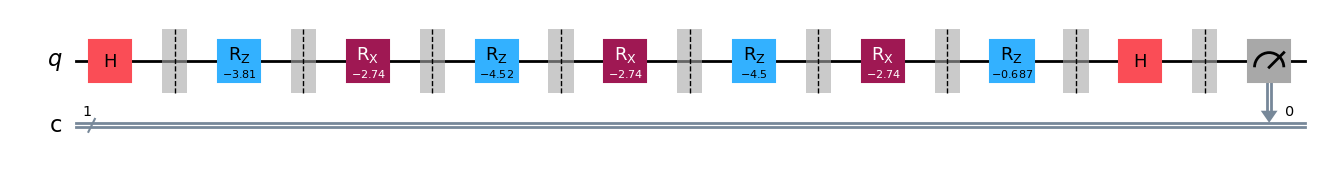

In [11]:
from qiskit import QuantumCircuit
import numpy as np
from qiskit_ibm_runtime import Sampler, Options


qc = QuantumCircuit(1,1)

# 2x

phi_3 = [0.3434281, 2.249998, 2.2590873, 1.9060472]
phi_3.reverse()

a = 0.2

qc.h(0)

qc.barrier(0)

for i in range(len(phi_3)):
    if(i != 0):
        qc.rx(-2*np.arccos(a),0)
        qc.barrier(0)
    qc.rz(-2*phi_3[i], 0)
    qc.barrier(0)

qc.h(0)

qc.barrier(0)

# measure all the qubits
qc.measure([0], [0])

qc.draw(output="mpl", style="iqp")

In [4]:
from qiskit_ibm_runtime import Sampler, Options

options = Options()
options.resilience_level = 1
options.optimization_level = 3

# Create an Estimator object
sampler = Sampler(backend_sim, options=options)

# Submit the circuit to Estimator
job = sampler.run(qc, shots=1000)

NameError: name 'backend_sim' is not defined

In [9]:
jobid = job.job_id()
print(f">>> Job ID: {job.job_id()}")
print(f">>> Job Status: {job.status()}")

NameError: name 'job' is not defined

In [15]:
retrieve_job = service.job(jobid)
result = retrieve_job.result()

In [16]:
from qiskit.visualization import plot_distribution

plot_distribution(result.quasi_dists[0].binary_probabilities())
print(result)

SamplerResult(quasi_dists=[{0: 0.128, 1: 0.872}], metadata=[{'shots': 1000, 'circuit_metadata': {}, 'readout_mitigation_overhead': 1.0, 'readout_mitigation_time': 0.024896160699427128, 'warning': 'Optimization level clipped from 3 to 1'}])


In [17]:
print(result.quasi_dists[0][0])

0.128


In [11]:
def gen_qc(a):
    qc = QuantumCircuit(1,1)

    # 2x

    phi_3 = [0.3434281, 2.249998, 2.2590873, 1.9060472]
    phi_3.reverse()

    qc.h(0)

    qc.barrier(0)

    for i in range(len(phi_3)):
        if(i != 0):
            qc.rx(-2*np.arccos(a),0)
            qc.barrier(0)
        qc.rz(-2*phi_3[i], 0)
        qc.barrier(0)

    qc.h(0)

    qc.barrier(0)

    # measure all the qubits
    qc.measure([0], [0])

    qc.draw(output="mpl", style="iqp")
    return qc

def gen_qc_full(a, phi_arr):
    qc = QuantumCircuit(1,1)

    # 2x

    phi_list = phi_arr.tolist()
    phi_list.reverse()

    qc.h(0)

    qc.barrier(0)

    for i in range(len(phi_list)):
        if(i != 0):
            qc.rx(-2*np.arccos(a),0)
            qc.barrier(0)
        qc.rz(-2*phi_list[i], 0)
        qc.barrier(0)

    qc.h(0)

    qc.barrier(0)

    # measure all the qubits
    qc.measure([0], [0])

    qc.draw(output="mpl", style="iqp")
    return qc

def eval_qc(qc):
    # Create an Estimator object
    sampler = Sampler(backend_sim, options=options)

    # Submit the circuit to Estimator
    job = sampler.run(qc, shots=100)
    jobid = job.job_id()
    retrieve_job = service.job(jobid)
    result = retrieve_job.result()
    return result

def eval_qc_list(qc_list):
    # Create an Estimator object
    sampler = Sampler(backend_sim, options=options)

    # Submit the circuit to Estimator
    job = sampler.run([x[1] for x in qc_list], shots=100)
    jobid = job.job_id()
    retrieve_job = service.job(jobid)
    result = retrieve_job.result()
    return result

job_ids = []

qc_list = []

for x in np.linspace(-1, 1, 21):
    qc_lcl = gen_qc(x)
    print(x)
    qc_list.append([x, qc_lcl])

#res = eval_qc_list(qc_list)

-1.0
-0.9
-0.8
-0.7
-0.6
-0.5
-0.3999999999999999
-0.29999999999999993
-0.19999999999999996
-0.09999999999999998
0.0
0.10000000000000009
0.20000000000000018
0.30000000000000004
0.40000000000000013
0.5
0.6000000000000001
0.7000000000000002
0.8
0.9000000000000001
1.0


In [136]:
'''
x = [u[0] for u in qc_list]
y1 = []
y2 = []
i = 0
for q in res.quasi_dists:
    zero_val = q
    if 0 in zero_val:
        zero_val = zero_val[0]
    else:
        zero_val = 0
    computed_y = np.sqrt(zero_val)
    actual_y = np.sin(2*x[i])
    print(f"For x = {x[i]}, computed y = {computed_y}, actual sin(2x) = {actual_y}")
    y1.append(computed_y)
    y2.append(actual_y)
    i += 1
'''

For x = -1.0, computed y = 0.8944271909999159, actual sin(2x) = -0.9092974268256817
For x = -0.9, computed y = 0.9848857801796105, actual sin(2x) = -0.9738476308781951
For x = -0.8, computed y = 1.0, actual sin(2x) = -0.9995736030415051
For x = -0.7, computed y = 0.9643650760992956, actual sin(2x) = -0.9854497299884601
For x = -0.6, computed y = 0.9273618495495703, actual sin(2x) = -0.9320390859672263
For x = -0.5, computed y = 0.8185352771872451, actual sin(2x) = -0.8414709848078965
For x = -0.3999999999999999, computed y = 0.714142842854285, actual sin(2x) = -0.7173560908995227
For x = -0.29999999999999993, computed y = 0.5477225575051661, actual sin(2x) = -0.5646424733950353
For x = -0.19999999999999996, computed y = 0.33166247903553997, actual sin(2x) = -0.3894183423086504
For x = -0.09999999999999998, computed y = 0.1414213562373095, actual sin(2x) = -0.19866933079506116
For x = 0.0, computed y = 0.0, actual sin(2x) = 0.0
For x = 0.10000000000000009, computed y = 0.173205080756887

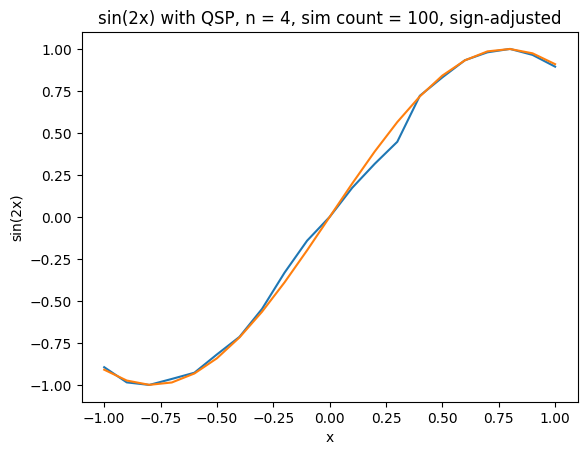

In [140]:
import matplotlib as mpl

mpl.pyplot.plot(x, np.sign(x) * y1)
mpl.pyplot.plot(x, y2)
mpl.pyplot.title("sin(2x) with QSP, n = 4, sim count = 100, sign-adjusted")
mpl.pyplot.xlabel("x")
mpl.pyplot.ylabel("sin(2x)")
mpl.pyplot.savefig("QSP_sim_4.png")

In [9]:
import matplotlib as mpl

In [139]:
o = {"x": x, "y_sim": y1, "y_actual": y2}
of = open("QSP_sim_4.json", "w")
json.dump(o, of)
of.close()

In [105]:
print(job_ids)

[[-1.0, SamplerResult(quasi_dists=[{0: 0.8, 1: 0.2}], metadata=[{'shots': 100, 'circuit_metadata': {}, 'readout_mitigation_overhead': 1.0, 'readout_mitigation_time': 0.011691818945109844, 'warning': 'Optimization level clipped from 3 to 1'}])], [-0.9, SamplerResult(quasi_dists=[{0: 0.92, 1: 0.08}], metadata=[{'shots': 100, 'circuit_metadata': {}, 'readout_mitigation_overhead': 1.0, 'readout_mitigation_time': 0.02065568696707487, 'warning': 'Optimization level clipped from 3 to 1'}])], [-0.8, SamplerResult(quasi_dists=[{0: 1.0}], metadata=[{'shots': 100, 'circuit_metadata': {}, 'readout_mitigation_overhead': 1.0, 'readout_mitigation_time': 0.006950044073164463, 'warning': 'Optimization level clipped from 3 to 1'}])], [-0.7, SamplerResult(quasi_dists=[{0: 0.94, 1: 0.06}], metadata=[{'shots': 100, 'circuit_metadata': {}, 'readout_mitigation_overhead': 1.0, 'readout_mitigation_time': 0.02080469485372305, 'warning': 'Optimization level clipped from 3 to 1'}])], [-0.6, SamplerResult(quasi_di

In [17]:
import matplotlib as mpl

Evaluating get_phi(19)
b = 1127.3929411716574
Finished evaluating get_phi(19)
-1.0
-0.9
-0.8
-0.7
-0.6
-0.5
-0.3999999999999999
-0.29999999999999993
-0.19999999999999996
-0.09999999999999998
0.0
0.10000000000000009
0.20000000000000018
0.30000000000000004
0.40000000000000013
0.5
0.6000000000000001
0.7000000000000002
0.8
0.9000000000000001
1.0
[[-1.0, <qiskit.circuit.quantumcircuit.QuantumCircuit object at 0x7fa807846850>], [-0.9, <qiskit.circuit.quantumcircuit.QuantumCircuit object at 0x7fa7546e4970>], [-0.8, <qiskit.circuit.quantumcircuit.QuantumCircuit object at 0x7fa78996dc40>], [-0.7, <qiskit.circuit.quantumcircuit.QuantumCircuit object at 0x7fa789f61ca0>], [-0.6, <qiskit.circuit.quantumcircuit.QuantumCircuit object at 0x7fa789da25b0>], [-0.5, <qiskit.circuit.quantumcircuit.QuantumCircuit object at 0x7fa78996dbe0>], [-0.3999999999999999, <qiskit.circuit.quantumcircuit.QuantumCircuit object at 0x7fa7893e0490>], [-0.29999999999999993, <qiskit.circuit.quantumcircuit.QuantumCircuit obje

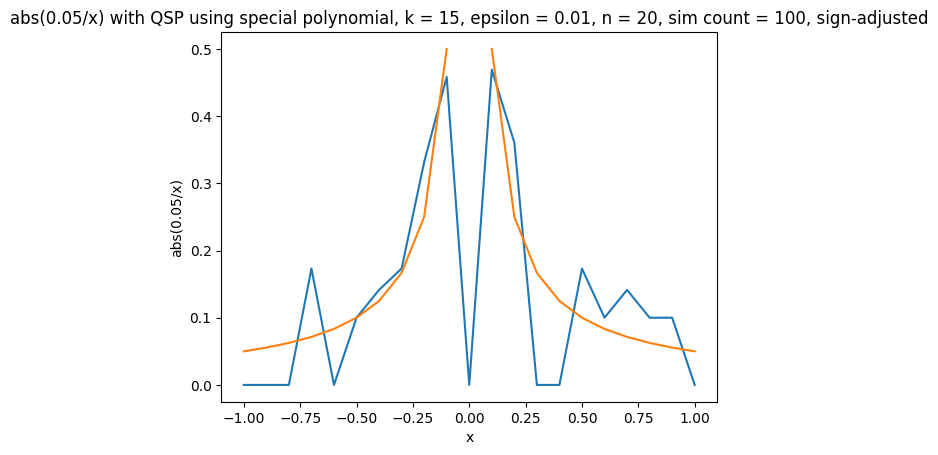

In [12]:
x_phi_arr = get_phi(19)
def run_everything(n):
    d = n - 1
    phi_arr = x_phi_arr
    qc_list = []
    for x in np.linspace(-1, 1, 21):
        qc_lcl = gen_qc_full(x, phi_arr)
        print(x)
        qc_list.append([x, qc_lcl])
    print(qc_list)
    res = eval_qc_list(qc_list)
    x = [u[0] for u in qc_list]
    y1 = []
    y2 = []
    i = 0
    for q in res.quasi_dists:
        zero_val = q
        if 0 in zero_val:
            zero_val = zero_val[0]
        else:
            zero_val = 0
        computed_y = np.sqrt(zero_val)
        if(x[i] != 0):
            actual_y = np.abs(0.05/x[i])
        else:
            actual_y = np.nan
        print(f"For x = {x[i]}, computed y = {computed_y}, actual 0.05/(x) = {actual_y}")
        y1.append(computed_y)
        y2.append(actual_y)
        i += 1
    print(y1)
    print(y2)
    mpl.pyplot.plot(x, y1)
    mpl.pyplot.plot(x, y2)
    mpl.pyplot.title(f"abs(0.05/x) with QSP using special polynomial, k = 15, epsilon = 0.01, n = {n}, sim count = 100, sign-adjusted")
    mpl.pyplot.xlabel("x")
    mpl.pyplot.ylabel("abs(0.05/x)")
    mpl.pyplot.savefig(f"QSP_sim_{n}_reci2.png")
    o = {"x": x, "y_sim": y1, "y_actual": y2}
    of = open(f"QSP_sim_{n}_reci2.json", "w")
    json.dump(o, of)
    of.close()
    of2 = open(f"QSP_sim{n}_phi_reci2.json", "w")
    o2 = {"phi": phi_arr}
    json.dump(o, of2)
    of2.close()
    
run_everything(20)

For x = -1.0, computed y = 0.9564230748153327, actual sin(2x) = -0.9092974268256817
For x = -0.9, computed y = 1.0539561325841624, actual sin(2x) = -0.9738476308781951
For x = -0.8, computed y = 1.0446126967802516, actual sin(2x) = -0.9995736030415051
For x = -0.7, computed y = 1.0256705123966467, actual sin(2x) = -0.9854497299884601
For x = -0.6, computed y = 1.0539561325841624, actual sin(2x) = -0.9320390859672263
For x = -0.5, computed y = 0.9251602934775416, actual sin(2x) = -0.8414709848078965
For x = -0.3999999999999999, computed y = 0.7625036161920036, actual sin(2x) = -0.7173560908995227
For x = -0.29999999999999993, computed y = 0.6664509454904374, actual sin(2x) = -0.5646424733950353
For x = -0.19999999999999996, computed y = 0.571410363855582, actual sin(2x) = -0.3894183423086504
For x = -0.09999999999999998, computed y = 0.3020193475168598, actual sin(2x) = -0.19866933079506116
For x = 0.0, computed y = 0.11306773954355921, actual sin(2x) = 0.0
For x = 0.10000000000000009, 

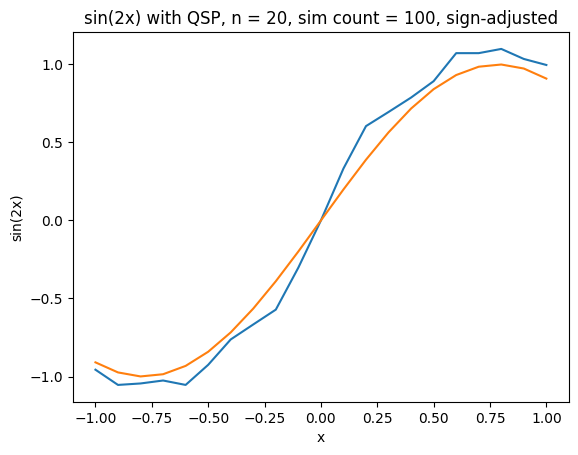

In [31]:
def data_extractor():
    n = 20
    retrieve_job = service.job("cpzja81dhsd0008e3hq0")
    res = retrieve_job.result()
    x = [x for x in np.linspace(-1, 1, 21)]
    y1 = []
    y2 = []
    i = 0
    for q in res.quasi_dists:
        zero_val = q
        if 0 in zero_val and zero_val[0] > 0:
            zero_val = zero_val[0]
        else:
            zero_val = 0
        computed_y = np.sqrt(zero_val)
        actual_y = np.sin(2*x[i])
        print(f"For x = {x[i]}, computed y = {computed_y}, actual sin(2x) = {actual_y}")
        y1.append(computed_y)
        y2.append(actual_y)
        i += 1
    mpl.pyplot.plot(x, np.sign(x) * y1)
    mpl.pyplot.plot(x, y2)
    mpl.pyplot.title(f"sin(2x) with QSP, n = {n}, sim count = 100, sign-adjusted")
    mpl.pyplot.xlabel("x")
    mpl.pyplot.ylabel("sin(2x)")
    mpl.pyplot.savefig(f"QSP_sim_{n}_actual.png")
    o = {"x": x, "y_sim": y1, "y_actual": y2}
    of = open(f"QSP_sim_{n}_actual.json", "w")
    json.dump(o, of)
    of.close()
    #of2 = open(f"QSP_sim{n}_phi_actual.json", "w")
    #o2 = {"phi": phi_arr}
    #json.dump(o, of2)
    #of2.close()
data_extractor()